In [1]:
import os
import time
import pandas as pd 
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras
import keras.backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model,load_model
from keras.initializers import glorot_uniform
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Add,ZeroPadding2D,AveragePooling2D,Input
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

In [90]:
#Declaring path Variables
root_dir=r'./'
train_csv_path=root_dir+'train_labels.csv'
valid_csv_path=root_dir+'validation_labels.csv'
test_csv_path=root_dir+'results.csv'
train_data_path=root_dir+'data/train/'
valid_data_path=root_dir+'data/valid/'
test_data_path=root_dir+'data/test/'

========================================================================================================================================================

Observation 1:

No.of unique labels in trainset :224

No.of unique labels in validset :223

No.of similar labels in both sets :219

Means train set has 5 labels which are not in valid set, valid set has 4 labels which are not in train set.

Conclusion 1:
  The 4 labels which are not present in train set cannot be predicted and so, removing those labels from validation set

========================================================================================================================================================

Observation 2:
Problem Statement says there are 15000 images in training set. However, it was found there are only 14720 images.

Conclusion 2:
Removing rows from training df when image is not found.

========================================================================================================================================================

In [12]:
# Method to load csv into df and changing imageId to filename
def load_df(path):
  df=pd.read_csv(path,index_col=False)
  if str(df['imageId'][0]).endswith('.jpg'):
    return df
  df['imageId']=df['imageId'].apply(str)+'.jpg'
  return df
# This method drops the rows if image not found in data
def check_and_drop_rows_if_image_doesnot_exists(df):
  for i in range(0,len(df)):
    if not os.path.isfile(train_data_path+str(df['imageId'][i])):
      df.drop(index=i,inplace=True,axis=0)
  df.reset_index(drop=True,inplace=True)
  return df

# Method to encode labels into columns
def one_hot_encode(df,columns): 
  # return if dataset is already encoded
  if len(df.columns)>10:
    return df
  #Else encode them now
  for column in columns:
    df[column]=0
  for i in range(len(df)):
    for column in columns:
      if column in df['labels'][i]:
        df[column][i]=1
  return df

# Method to get all the labels present in a given dataset
def get_labels_and_freq(df):
  dict=defaultdict(int)
  for i in range(len(df)):
    labels=df['labels'][i]
    labels=labels[1:-1].split(',')
    for label in labels:
      dict[label.strip()]+=1
  return dict

# Method to get all unique labels in the dataset
def get_labels(df):
  classes=[]
  for i in range(len(df)):
    labels=df['labels'][i]
    labels=labels[1:-1].split(',')
    for label in labels:
      classes.append(label.strip())
  return np.unique(classes)

# Method that removes given labels from the dataset

def remove_labels_from_data(df,remove_labels):
  for i in range(len(df)):
    labels=df['labels'][i]
    labels=labels[1:-1].split(',')
    new_labels="["
    for label in labels:
      if label.strip() not in remove_labels:
        new_labels=new_labels+label+','
    df['labels'][i]=new_labels+']'
  return df

  
# Method to plot the freq of classes in given dataset
def plot_label_freq(df,name):
  label_dict=get_labels_and_freq(df)
  fig=plt.figure(figsize=(20,5))
  plt.title(name)
  
  plt.bar(label_dict.keys(),label_dict.values(), 2, color='g')
  plt.show()

In [13]:
train_df=load_df(train_csv_path)
train_labels=get_labels_and_freq(train_df).keys()
# plot_label_freq(train_df,'train_label_freq')

valid_df=load_df(valid_csv_path)
valid_labels=get_labels_and_freq(valid_df).keys()
# plot_label_freq(valid_df,'valid_label_freq')

In [14]:
labels_to_be_removed=[]
for i in list(valid_labels):
  if i not in list(train_labels):
    labels_to_be_removed.append(i)
print(labels_to_be_removed)

["u'194'", "u'145'", "u'163'", "u'156'"]


We will remove the above four classes from validation set, since they are not present in train set, model cannot predict those values anyways.

In [15]:
valid_df=remove_labels_from_data(valid_df,labels_to_be_removed)


There are 280 images which are mentioned in training dataset are not actually present in train folder, lets delete those rows

In [16]:
train_df=check_and_drop_rows_if_image_doesnot_exists(train_df)
print(len(train_df))

14720


One hot encoding the labels in given dataset to feed the neural network. We will be loading this saved dataset in the future instead of original dataset.

In [17]:
# Donot Run this cell if you loaded already encoded csv file.
train_df=one_hot_encode(train_df,train_labels)
valid_df=one_hot_encode(valid_df,train_labels)
train_df.to_csv('train_df_encoded.csv',index=False)
valid_df.to_csv('valid_df_encoded.csv',index=False)

Lets Plot the frequency of labels in the dataset

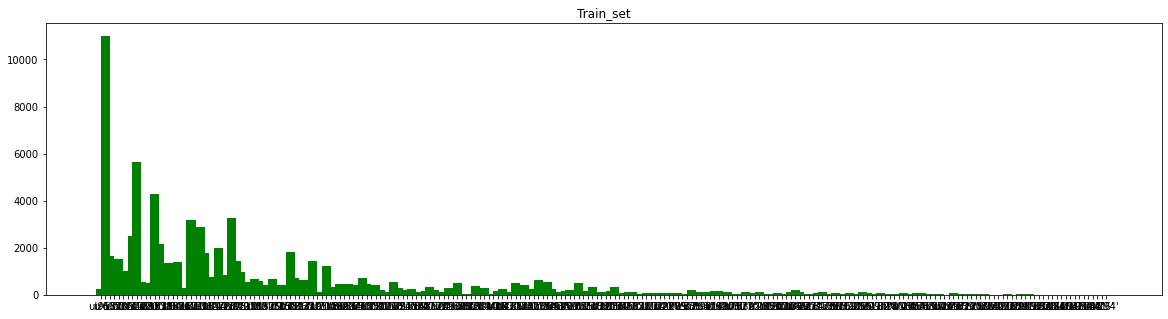

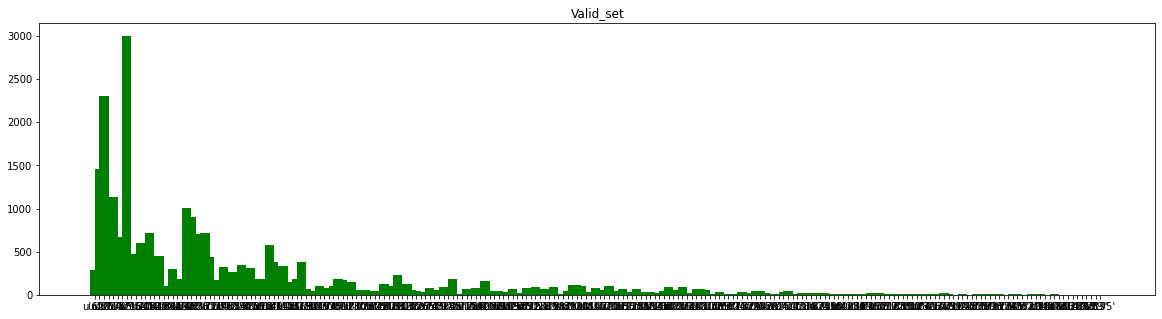

In [18]:
plot_label_freq(train_df,'Train_set')
plot_label_freq(valid_df,'Valid_set')

Woah!! The labels are clearly imbalanced i.e,some labels have only appeared once. It will be really hard to predict on those labels. But lets try!

Approach 1: 

We may use label power set transform on our dataframe and convert this multi label classification problem into multi class prediction problem.. However, the no.of output classes will become (2^no.of unique classes). In this case,it is (2^224).
This approach can be used only when the number of unique labels are low say 1-6

Approach 2:

We may introduce class weights to every label and penelize more for classes with high freq in our loss function.
This is a likely and feasible solution. So, lets try it out. 

In [20]:
#calculate weights
def calculating_class_weights(df):
  classes=[]
  for i in range(len(train_df)):
    labels=train_df['labels'][i]
    labels=labels[1:-1].split(',')
    for label in labels:
      classes.append(label.strip())
  classes=np.unique(classes)
  dim = np.shape(classes)[0]
  weights = np.empty([dim, 2])
  for i in range(len(classes)):
      weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=df[classes[i]])
  return weights


weights=calculating_class_weights(train_df)
np.shape(weights)



(224, 2)

In [50]:
#custom loss function
def get_weighted_loss(weights):
  def weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))* K.binary_crossentropy(y_true, y_pred), axis=-1)
  return weighted_loss

In [66]:
# Data generators

train_dataGen = ImageDataGenerator(
                                  rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range = 0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  )
                
valid_dataGen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataGen.flow_from_dataframe(dataframe=train_df,
                                                    directory=train_data_path,
                                                    x_col='imageId',
                                                    y_col=train_labels,
                                                    class_mode='raw',
                                                    target_size=(256,256),
                                                    batch_size=10,
                                                    shuffle=True,
                                                    )


valid_generator = valid_dataGen.flow_from_dataframe(dataframe=valid_df,
                                                    directory=valid_data_path,
                                                    x_col='imageId',
                                                    y_col=train_labels,
                                                    class_mode='raw',
                                                    target_size=(256,256),
                                                    batch_size=10,
                                                    shuffle=False,
                                                    )



Found 14720 validated image filenames.
Found 3000 validated image filenames.


In [24]:
# Convolutional Neural Network
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(700, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(224, activation='sigmoid'))

model.compile(loss=get_weighted_loss(weights), optimizer='adam', metrics=['accuracy'])

In [25]:
# callback for implement decaying learning rate
lrr= ReduceLROnPlateau(   monitor='val_accuracy',   factor=.01,   patience=3,  min_lr=0.001)

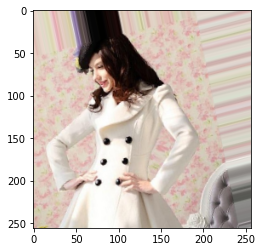

In [52]:
X,y = train_generator[0]
np.shape(X)
plt.imshow(X[0])

In [53]:
history=model.fit(train_generator,
          epochs=5,
          validation_data=valid_generator,
          callbacks=[lrr])

Epoch 1/5
1472/1472 [==============================] - 174s 118ms/step - loss: 0.9758 - accuracy: 0.5371 - val_loss: 2.8899 - val_accuracy: 0.7500
Epoch 2/5
1472/1472 [==============================] - 173s 118ms/step - loss: 0.9513 - accuracy: 0.6330 - val_loss: 3.3102 - val_accuracy: 0.7500
Epoch 3/5
1472/1472 [==============================] - 176s 120ms/step - loss: 0.9466 - accuracy: 0.6431 - val_loss: 2.0820 - val_accuracy: 0.7500
Epoch 4/5
1472/1472 [==============================] - 177s 120ms/step - loss: 0.9421 - accuracy: 0.6734 - val_loss: 1.6786 - val_accuracy: 0.7500
Epoch 5/5
1472/1472 [==============================] - 178s 121ms/step - loss: 0.9355 - accuracy: 0.6721 - val_loss: 2.2430 - val_accuracy: 0.7500


In [55]:
model.save('model_approach-classweights.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


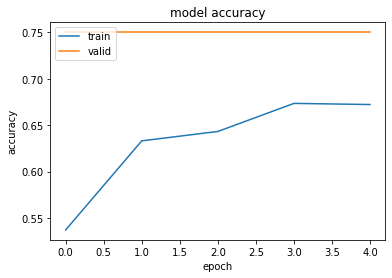

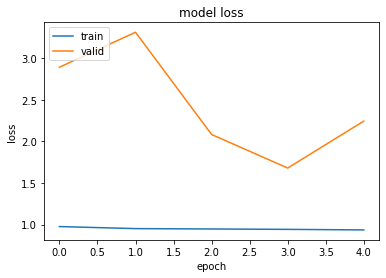

In [60]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [91]:
#Getting filenames in test directory
test_images=os.listdir(test_data_path)
np.shape(test_images)

(6895,)

In [ ]:
model=load_model('model_approach-classweights.h5', custom_objects={"weighted_loss": get_weighted_loss(weights)})

In [93]:
# Loading the test images in batches,
# Predicting the classes using the above model and saving the values in a dictionary.

batch_size=6895
steps=(len(test_images)//batch_size)
step=0
results={}
while(step<steps):

  # separating the batch from total data
  start=step*batch_size
  end=start+batch_size
  if end>len(test_images):
    end=len(test_images)
  batch=test_images[start:end]
  batch_images=[]

  # loading imgs
  for img in batch:
    img=image.load_img(test_data_path+str(img),target_size=(256,256,3))
    img=np.array(img)
    img=img/255
    batch_images.append(img)
  print(f'batch: {step+1}/{steps}')

  # predicting 
  batch_result=[]
  for img in batch_images:
    img=np.reshape(img,(1,256,256,3))
    result=model.predict(img)
    result_bool=(result > 0.5)
    batch_result.append(result_bool)
  for i in range(len(batch_result)):
    results[batch[i]]=batch_result[i]
  
  #next batch
  step+=1

batch: 1/1


In [124]:
# This section of code converts the predicted values to labels
results_with_labels={}
train_labels=list(train_labels)
for key,value in results.items():
  label='['
  for i in range(len(value[0])):
    # print(value[0][i])
    # print(train_labels[i])
    if value[0][i]:
      label=label+train_labels[i]+','
  results_with_labels[key]=label+']'

In [130]:
results_df = pd.DataFrame(data=results_with_labels.items(),columns=['imageId','label'])
results_df.to_csv('results.csv',index=False)
results_df.head()

,imageId,label
0,3001.jpg,"[u'95',u'66',u'137',u'70',u'20',u'36',u'44',u'..."
1,3002.jpg,"[u'95',u'66',u'137',u'70',u'20',u'36',u'44',u'..."
2,3003.jpg,"[u'95',u'66',u'137',u'70',u'20',u'36',u'44',u'..."
3,3004.jpg,"[u'95',u'66',u'137',u'70',u'20',u'36',u'44',u'..."
4,3005.jpg,"[u'95',u'66',u'137',u'70',u'20',u'36',u'44',u'..."


It looks like the model has hit a local minimum. It is basically predicting labels with high freq to all the images. This is a very bad model.

Defining classweights didnot work, we can try using approaches like,

1.UnderSampling: this method reduces the examples of high freq labels provided to the model. This results in loss of data.

2.Random OverSampling: This method basically selects a sample of miniority class and suggests it multiple times to the model. In our dataset we have many labels with freq less than 50, model might overfit to these examples and perform badly on valid or test data anyways.

This brings us to a relatively new approach, based on this research paper https://arxiv.org/pdf/2105.02340.pdf

3.Deep SMOTE: SMOTE means Synthetic Minority OverSampling technique, it is a technique used to balance the imbalanced datasets in machinelearning problems by generating new data. As mentioned in the paper this approach can be used to balance an image data through usage of encoder and decoder networks. Need more time to try this approach.

